# How to use ATLAS Open Data

This notebook shows you how to access and analyse ATLAS Open Data https://opendata.atlas.cern

## ATLAS Open Data Initialisation

### First time package installation on your computer or server

This first cell installs the required python packages.
It only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

In [1]:
import sys
# # update the pip package installer
!{sys.executable} -m pip install --upgrade --user pip
# # install required packages
!{sys.executable} -m pip install --upgrade --user uproot awkward vector matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.4/879.4 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: awkward-cpp
    Found existing installation: awkward_cpp 44
    Uninstalling awkward_cpp-44:
      Successfully uninstalled awkward_cpp-44
  Attempting uninstall: awkward
    Found existing installation: awkward 2.7.4
    Uninstalling awkward-2.7.4:
      Successfully uninstalled awkward-2.7.4


In [2]:
#hopefully this works, terminal history also had 
#pip install --user uproot
!{sys.executable} -m pip install --user numpy==2.0.2
!{sys.executable} -m pip install --user requests
!{sys.executable} -m pip install --user aiohttp

We're going to import a number of packages to help us:
* `numpy`: provides numerical calculations such as histogramming
* `matplotlib`: common tool for making plots, figures, images, visualisations
* `uproot`: processes `.root` files typically used in particle physics into data formats used in python
* `awkward`: introduces `awkward` arrays, a format that generalizes `numpy` to nested data with possibly variable length lists
* `vector`: to allow vectorized 4-momentum calculations

We also import the file `infofile`, which contains all relevant information of our dataset. This python file `infofile.py` must be in the same folder as the notebook or otherwise added to the `PYTHONPATH` environment variable

In [1]:
import sys #reimport sys so we have it when not running package installation/setup
import infofile # local file containing cross-sections, sums of weights, dataset IDs
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
from matplotlib.gridspec import GridSpec

#suspicious this is necessary, never had to do it before!
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format

from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time

In [2]:
#should also import some nice hep plot style here

Unit definitions, as stored in the data files

In [3]:
MeV = 0.001
GeV = 1.0

## Step 1: Reading data 

We would like to read some of the data from the open dataset.

In [4]:
# ATLAS Open Data directory for simulation and data
# this folder is viewable in a browser
path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/"

#information on these datasets: https://atlas-opendata.web.cern.ch/docs/datasets/intro
skims = ['4lep','3lep','2lep','1lep','1largeRjet1lep','1lep1tau','GamGam']
#we don't necessarily need the list - but it's handy to know what's available. 
#We could e.g. use this to list all datasets on the website
#within each of these skims there is both data and a selection of simulated processes
#the different simulated samples are listed here: https://atlas-opendata.web.cern.ch/docs/datasets/mc
#not all processes are available for each channel
#and maybe I have missed some!
#BSM processes not included  - you need to add those yourself!

In [5]:
# from PIL import Image
# from IPython.display import display
# display(Image.open('opendata_mc_table.png'))

Note that this table is missing the $ttZ(\rightarrow ee,\mu\mu)$ samples that are also available (and important in specific areas of phase space!)
For convenient naming and identification purposes,
    we define a dictionary which stores all the important names of the samples we want to pull from the directory.

In [6]:
# categories of samples we'll use (can designate your own!)
# include the plotting colour and name in the legend
# make your own good colour scheme: https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations
# should be accessible!

samples = {
    'data': {
        'list' : ['data_A','data_B','data_C','data_D'], # data is from 2016, first four periods of data taking (ABCD)
    },
    'Zjets' : { # Z(ll) + jets
        'list' : ['Zee','Zmumu','Ztautau'],
        'color' : "#8fd7d7",
        'legend': r'$Z+$jets'
    },
    'susy_WZ' : { # w(vl)+Z(ll)
        'list' : ['C1N2_WZ_100p0_0p0_3L_2L7','C1N2_WZ_350p0_0p0_3L_2L7','C1N2_WZ_400p0_0p0_3L_2L7','C1N2_WZ_500p0_0p0_3L_2L7'],
        'color' : "#00b0be",
        'legend': r'WZ'
    },
    'Wjets' : { # W(lv)+jets
        'list' : ['Wplusenu','Wminusenu','Wplusmunu','Wminusmunu','Wplustaunu','Wminustaunu'],
        'color' : "#00b0be",
        'legend': r'$W+$jets'
    },
    'diboson_leptonic' : { # Diboson, both decay leptonically
        'list' : ['llll','lllv','llvv','lvvv'],
        'color' : "#ff8cal",
        'legend' : 'Diboson (fully leptonic)'
    },
    'diboson_semileptonic' : { # Diboson, one decays hadronically
        'list' : ['ZqqZll','WqqZll','WpqqWmlv','WplvWmqq','WlvZqq'],
        'color' : "#f45f74",
        'legend' : 'Diboson (semi-leptonic)'
    },
    'HZZ4l' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#bdd373",
        'legend' : r'$H(125)\rightarrow ZZ \rightarrow llll$',
    },
    'Hyy': { #Higgs -> gamma gamma
        'list' : ['ggH125_gamgam','VBFH125_gamgam','ttH125_gamgam','ZH125J_Zincl_gamgam','WpH125J_Wincl_gamgam'],
        'color' : "#98c127",
        'legend' : r'$H(125)\rightarrow ZZ \rightarrow llll$',

    },
    'HWW': { #Higgs -> WW -> lv lv
        'list' : ['VBFH125_WW2lep','ggH125_WW2lep','WpH125J_qqWW2lep','WpH125J_lvWW2lep','ZH125J_qqWW2lep','ZH125J_llWW2lep','ZH125J_vvWW2lep'],
        'color' : "#ffcd8e",
        'legend' : r'$H(125)\rightarrow WW \rightarrow lvlv$',
    },
    'top':{ #processes with a top quark (single top, ttbar)
        'list' : ['ttbar_lep','single_top_tchan','single_antitop_tchan','single_top_wtchan','single_antitop_wtchan',
                  'single_top_schan','single_antitop_schan','ttW','ttee','ttmumu'],
        'color' : "#ffb255",
        'legend' : r'Top processes',
    },  
}

The key named `data` refers to the event information collected from real experiments,
    while the `Background` and `Signal` keys refer to Monte-Carlo (MC) simulations of the ATLAS experiments.
Both real data and MC data will then be analysed and compared together to discover the Higgs! 

Let's try accessing `data_A` in the Open Data URL as an example.

In [7]:
# Print the samples dict for the key 'data'
print(samples['data'])

# We shall use the first entry in 'list', 'data_A'
value = samples['data']['list'][2]
print(f"{value=}")

skim_3lep = skims[1]

# This is now appended to our file path to retrieve the data_A.4lep.root file
data_A_path = path +skim_3lep + "/Data/" + value + "."+skim_3lep+".root"
print("Path I will try to access the data from:",data_A_path)
#Warning: if you clik the link it will download the file locally!

{'list': ['data_A', 'data_B', 'data_C', 'data_D']}
value='data_C'
Path I will try to access the data from: https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/Data/data_C.3lep.root


Next, we shall try opening the `data_A` file to see what is inside.
In the file (called a `tree`),
    there are 39 entries, 
    one for each event.
In each event,
    a dictionary stores the all relevant information as keys, such as the event number (`eventNumber`), lepton transverse momentum (`lep_pt`), etc.  
Details on the variables in the dictionary can be viewed [here](https://cds.cern.ch/record/2707171/files/ANA-OTRC-2019-01-PUB-updated.pdf) in Appendix A.

More information on trees can be viewed [here](https://masonproffitt.github.io/uproot-tutorial/03-trees/index.html).

In [8]:
# Accessing a single file from the online directory (":mini" opens the tree in a desired manner)
# in practice we'll want to loop through many files! But let's test just the data.
#uproot: https://uproot.readthedocs.io/en/stable/basic.html
# See how many events there are in the file

#The bottom command only works locally, not with a file streamed by https
#data_A_path = "data_A.2lep.root"
#tree = uproot.open(data_A_path + ":mini",entrystart=0, entrystop=100) #only load 100 here so we don't break anything!

print(next(uproot.num_entries(data_A_path + ":mini")))#use next b/c it returns an iterator. bizarre.

#can also do: tree.num_entries once the tree is loaded

tree = uproot.open(data_A_path + ":mini")
print(tree.keys())

# We can also view the entire tree using the .arrays() method
#print(tree.arrays()) 
#but this is not so helpful of a view.

('https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/Data/data_C.3lep.root', 'mini', 20992)
['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER', 'trigE', 'trigM', 'trigP', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_jvt', 'jet_trueflav', 'jet_truthMatched', 'jet_MV2c10', 'photon_n', 'photon_truthMatched', 'photon_trigMatched', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_E', 'photon_isTightID', 'photon_ptcone30', 'photon_etcone20', 'photon_convType', 'tau_n', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 'tau_isTightID', 'tau_truthMatche

Perhaps we'd like to see the lepton energies. 
We can access this from our tree using the key `lep_E`. 
Also, 
    from this point on we shall be manipulating our tree arrays using the `awkward` library.
We can use `library="ak"` in the argument of the `.arrays()` method to use this library.
If you ever see `library="ak"` in the code,
    it means that the array is output as an `awkward` array.

In [9]:
#This is showing two lepton energies per event - because we chose a 2lep skim!
#only show the first ten events - 66,000 would be way too many!
# tree["lep_E"].array(library="ak")[:10]
#awkward: https://awkward-array.org/doc/main/user-guide/index.html
tree["jet_pt"].array(library="ak")[:10]

<Array [[2.25e+04], [3.56e+04, ...], [], ..., [], []] type='10 * var * float32'>

In our analysis, 
    not all the information in the tree is important.
We can store the important variables in a list and retrieve them from the tree later on.
As it turns out, 
    we will need the following set of variables:

In [10]:
# Define what variables are important to our analysis
# we can use certain uproot methods to load only these variables rather than the full tree
variables = ['lep_pt','lep_eta','lep_phi','lep_E','lep_charge','lep_type','met_et','met_phi','lep_isTightID']

# To see all the data for our given variables
# for data in tree.iterate(variables, library="ak"):
#     print(data)

Now that we understand how to access the information in the `data_A` tree,
    we can begin analysis.
As mentioned in the introduction,
    there are two key steps to be completed for each event entry:
1. **Application of selection requirements** - we need to account for lepton selection rules in the event (and perhaps other event selection, to be determined by you)!
For example, if we want a Z boson, we we must two leptons with the **same flavour** and **opposite charge** (OSSF).
The datasets used in this notebook have already been filtered to include exactly 2 leptons per event.
We need to filter the data such that in each event, there are pairs of leptons of the **same lepton type** (`lep_type`) and summing to **zero lepton charge** (`lep_charge`).

2. **Variable calculations** - We need to calculate the variable we want to plot. For example, the invariant mass of the lepton pair.

Let's try to perform this two-step analysis for **one event** in `data_A`.

In [11]:
# This selects the first entry of the tree - from entry 0 to entry 1, for example.
# but careful, it loads the WHOLE tree into arrays then selects event 1... only works for small files!
entry = tree.arrays(variables, library="ak")[0:1]
print(entry)

# Cut lepton type (electron type is 11,  muon type is 13)
#there should always be 4 of these in 4lep events
#we take entry 0 because the type is a list of events - we have one event, so just take the first (only) entry
lep_types = entry['lep_type'][0] 
lep_charges = entry['lep_charge'][0]

#we want opposite sign, same flavour pairs
sum_lep_type = sum(lep_types)
sum_lep_charge = sum(lep_charges)
print(lep_types,lep_charges)
#print(sum_lep_type,sum_lep_charge)
pass_OSSF_pair = ((sum_lep_type == 22) | (sum_lep_type == 26)) & sum_lep_charge==0

print(f"Passes our lepton flavour and charge requirements? {pass_OSSF_pair}") 
# False means we should remove this entry 

if pass_OSSF_pair:
    # Calculate invariant mass of the two leading leptons
    p4 = vector.zip({"pt": entry['lep_pt'][0], "eta": entry['lep_eta'][0], "phi": entry['lep_phi'][0], "E": entry['lep_E'][0]})
    invariant_mass = (p4[0] + p4[1]).M * MeV # .M calculates the invariant mass
    print(f"Invariant mass: {invariant_mass} GeV")

[{lep_pt: [8.87e+04, ..., 3.83e+04], lep_eta: [0.0464, ...], lep_phi: ..., ...}]
[13, 11, 11] [-1, 1, -1]
Passes our lepton flavour and charge requirements? True
Invariant mass: 119.89466857910156 GeV


Based on our analysis, the first entry should be removed because the lepton type does not match our requirements.
We can turn these checks and calculations into a set of functions.

In [34]:
# Selection on lepton type (electron type is 11,  muon type is 13)
def lep_type_selection(lep_type):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2]
    lep_type_fail = (sum_lep_type != 33) & (sum_lep_type != 35) & (sum_lep_type != 39) & (sum_lep_type != 37)
    return lep_type_fail # True means we should remove this entry (lepton type does not match)

# Selection on lepton charge
def lep_charge_selection(lep_charge):
    # first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    sum_charge_fail = abs(lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2])!= 1
    return sum_charge_fail # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Selection on lepton charge
def lep_id_select(lep_id):
    type_pass = ak.all(lep_id,axis=1)
    return type_pass # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Calculate invariant mass of the 2-lepton state
# [:, i] selects the i-th lepton in each event
def calc_mass(lep_pt, lep_eta, lep_phi, lep_E):
    p4_1 = vector.obj(pt=lep_pt[0], eta=lep_eta[0], phi=lep_phi[0], E=lep_E[0])
    p4_2 = vector.obj(pt=lep_pt[1], eta=lep_eta[1], phi=lep_phi[1], E=lep_E[1])
    invariant_mass = (p4_1 + p4_2).M * MeV # .M calculates the invariant mass
    return invariant_mass

def calc_pt(lep_pt, lep_eta, lep_phi, lep_E):
    p4_1 = vector.obj(pt=lep_pt[0], eta=lep_eta[0], phi=lep_phi[0], E=lep_E[0])
    p4_2 = vector.obj(pt=lep_pt[1], eta=lep_eta[1], phi=lep_phi[1], E=lep_E[1])
    pt = (p4_1 + p4_2).pt * MeV # .M calculates the invariant mass
    return pt

def diff_flave_lep(lep_type):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2]
    diff_ind = 1
    lep_diff = (sum_lep_type == 37) | (sum_lep_type == 35)
    return lep_diff

def calc_diff_ind(lep_types):
    sorted_leps = np.sort(lep_types, axis=1)
    first_two_equal = sorted_leps[:, 0] == sorted_leps[:, 1]
    last_two_equal = sorted_leps[:, 1] == sorted_leps[:, 2]
    diff_index_in_sorted = np.where(first_two_equal, 2, np.where(last_two_equal, 0, 1))
    unique_values = np.take_along_axis(sorted_leps, diff_index_in_sorted[:, np.newaxis], axis=1)
    diff_indices = (lep_types != unique_values[:, np.newaxis])
    return ak.argmax(~diff_indices, axis = 1)
    
# def trans_mass_calc(data, w = None):
#     lep_pt = data['lep_pt']
#     miss_e = data['met_et']
#     miss_phi = data['met_phi']
#     lep_phi = data['lep_phi']
#     lep_eta = data['lep_eta']
#     lep_E = data['lep_E']
#     diff_ind = data['diff_index']
#     mts = []
#     invariant_masses = []
#     mc_weight_mask = []
#     for event in range(len(miss_e)-1):
#         leps = [0,1,2]
#         z_bose = leps.pop(diff_ind[event][0])
#         mc_weight_mask += [False]
       
#         inv_mass = calc_mass(lep_pt[event][leps],lep_eta[event][leps],lep_phi[event][leps],lep_E[event][leps])
#         #print(lep_type[event],lep_charge[event],inv_mass)
#         print(event,len(miss_e))
#         if abs(sum(lep_charge[event][leps])) != 0:
#             continue
#         #print(lep_pt[event][leps],lep_eta[event][leps],lep_phi[event][leps],lep_E[event][leps])
#         #inv_mass = calc_mass(lep_pt[event][leps],lep_eta[event][leps],lep_phi[event][leps],lep_E[event][leps])

#         E_miss = miss_e[event]
#         if E_miss < 30000: 
#              continue
#         if inv_mass < 81.18 or inv_mass > 101.18:
#            continue
#         invariant_masses.append(inv_mass)

#         pt_l = lep_pt[event][diff_ind[event][0]]
#         phi_l = lep_phi[event][diff_ind[event][0]]
#         E_miss = miss_e[event]
#         E_phi_miss = miss_phi[event]
#         p_vec = vector.obj(pt=pt_l, phi=phi_l)
#         e_vec = vector.obj(pt=E_miss, phi=E_phi_miss)

#         del_phi = p_vec.deltaphi(e_vec)

#         Mt = 0.001*np.sqrt(2*pt_l*E_miss*(1-np.cos(del_phi)))
#         mts.append(Mt)
#         if w is not None:
#             mc_weight_mask[-1] = True
#     if w is not None:
#         return [mts,invariant_masses,w[mc_weight_mask]]

#     return [mts,invariant_masses]

# def trans_mass_calc(data, w = None):
#     lep_pt = data['lep_pt']
#     miss_e = data['met_et']
#     miss_phi = data['met_phi']
#     lep_phi = data['lep_phi']
#     lep_eta = data['lep_eta']
#     lep_E = data['lep_E']
#     lep_type = data['lep_type']
#     lep_charge = data['lep_charge']
#     mts = []
#     invariant_masses = []
#     mc_weight_mask = []
#     for event in range(len(miss_e)):
#         leps = [0,1,2]
#         sum_lep = sum(lep_type[event])
#         mc_weight_mask += [False]
#         if sum_lep == 35: 
#             diff_ind = list(lep_type[event]).index(13)
#         elif sum_lep == 37: 
#             diff_ind = list(lep_type[event]).index(11)
       
#         z_bose = leps.pop(diff_ind)
                                                                                                                             
#         #print(lep_type[event],lep_charge[event],inv_mass)
#         if abs(sum(lep_charge[event][leps])) != 0:
#             continue
#         #print(lep_pt[event][leps],lep_eta[event][leps],lep_phi[event][leps],lep_E[event][leps])
#         inv_mass = calc_mass(lep_pt[event][leps],lep_eta[event][leps],lep_phi[event][leps],lep_E[event][leps])

#         E_miss = miss_e[event]
#         if E_miss < 30000: 
#              continue
#         if inv_mass < 81.18 or inv_mass > 101.18:
#            continue
        

#         pt_l = lep_pt[event][diff_ind]
#         phi_l = lep_phi[event][diff_ind]
#         E_miss = miss_e[event]
#         E_phi_miss = miss_phi[event]
#         p_vec = vector.obj(pt=pt_l, phi=phi_l)
#         e_vec = vector.obj(pt=E_miss, phi=E_phi_miss)

#         del_phi = p_vec.deltaphi(e_vec)

#         Mt = 0.001*np.sqrt(2*pt_l*E_miss*(1-np.cos(del_phi)))
#         if Mt < 30:
#             continue
#         mts.append(Mt)
#         invariant_masses.append(inv_mass)
#         if w is not None:
#             mc_weight_mask[-1] = True
#     if w is not None:
#         return [mts,invariant_masses,w[mc_weight_mask]]

#     return [mts,invariant_masses]

def trans_mass_calc(data, w = None):
    lep_pt = data['lep_pt']
    miss_e = data['met_et']
    miss_phi = data['met_phi']
    lep_phi = data['lep_phi']
    lep_eta = data['lep_eta']
    lep_E = data['lep_E']
    lep_type = data['lep_type']
    lep_charge = data['lep_charge']
    mts = []
    invariant_masses = []
    emiss = []
    pt_z = []
    net_charge = []
    mc_weight_mask = []
    for event in range(len(miss_e)):
        leps = [0,1,2]
        sum_charge = sum(lep_charge[event])
        mc_weight_mask += [False]
        if sum_charge == 1: 
            diff_ind = list(lep_charge[event]).index(-1)
        elif sum_charge == -1: 
            diff_ind = list(lep_charge[event]).index(1)
        
        z_bose = leps.pop(diff_ind)
        
        inv_mass1 = calc_mass([lep_pt[event][diff_ind],lep_pt[event][leps[0]]],[lep_eta[event][diff_ind],lep_eta[event][leps[0]]],[lep_phi[event][diff_ind],lep_phi[event][leps[0]]],[lep_E[event][diff_ind],lep_E[event][leps[0]]])
        inv_mass2 = calc_mass([lep_pt[event][diff_ind],lep_pt[event][leps[1]]],[lep_eta[event][diff_ind],lep_eta[event][leps[1]]],[lep_phi[event][diff_ind],lep_phi[event][leps[1]]],[lep_E[event][diff_ind],lep_E[event][leps[1]]])
        if 81.18 < inv_mass1 < 101.18 and (lep_type[event][diff_ind] == lep_type[event][leps[0]]):
            inv_mass = inv_mass1
            pt_tot = calc_pt([lep_pt[event][diff_ind],lep_pt[event][leps[0]]],[lep_eta[event][diff_ind],lep_eta[event][leps[0]]],[lep_phi[event][diff_ind],lep_phi[event][leps[0]]],[lep_E[event][diff_ind],lep_E[event][leps[0]]])
            w_ind =leps[1]
        elif 81.18 < inv_mass2 < 101.18 and (lep_type[event][diff_ind] == lep_type[event][leps[1]]):
            inv_mass = inv_mass2
            pt_tot = calc_pt([lep_pt[event][diff_ind],lep_pt[event][leps[1]]],[lep_eta[event][diff_ind],lep_eta[event][leps[1]]],[lep_phi[event][diff_ind],lep_phi[event][leps[1]]],[lep_E[event][diff_ind],lep_E[event][leps[1]]])
            w_ind =leps[0]
        else:
            continue
        
        E_miss = miss_e[event]
        if E_miss < 30000: 
             continue
        pt_l = lep_pt[event][w_ind]
        phi_l = lep_phi[event][w_ind]
        E_miss = miss_e[event]
        E_phi_miss = miss_phi[event]
        p_vec = vector.obj(pt=pt_l, phi=phi_l)
        e_vec = vector.obj(pt=E_miss, phi=E_phi_miss)

        del_phi = p_vec.deltaphi(e_vec)

        Mt = 0.001*np.sqrt(2*pt_l*E_miss*(1-np.cos(del_phi)))
        if Mt < 30:
            continue
        pt_z.append(pt_tot)
        invariant_masses.append(inv_mass)
        mts.append(Mt)
        emiss.append(0.001*E_miss)
        net_charge.append(sum(lep_charge[event]))
        if w is not None:
            mc_weight_mask[-1] = True
    if w is not None:
        return [mts,invariant_masses,w[mc_weight_mask],emiss,pt_z,net_charge]

    return [mts,invariant_masses,emiss,pt_z]

def calc_mass_easy(miss_e,miss_phi,lep_pt,lep_phi):
    return

def lep_pt_selection(lep_pt):
    return (lep_pt[:,0] >= 25000) & ( lep_pt[:,1] >= 20000) & (lep_pt[:,2] >= 20000)

def process_events(data, data_w = None):
        lep_id = data['lep_isTightID']
        data = data[lep_id_select(lep_id)]
        lep_type = data['lep_type']
        data = data[~lep_type_selection(lep_type)]
        lep_charge = data['lep_charge']
        data = data[~lep_charge_selection(lep_charge)]
        lep_pt = data['lep_pt']
        data = data[lep_pt_selection(lep_pt)]
        # lep_type_skim_1 = data['lep_type']
        # data_diff = data[diff_flave_lep(lep_type_skim_1)]
        
        if data_w is not None:
            data_w = data_w[list(lep_id_select(lep_id))]
            data_w = data_w[list(~lep_type_selection(lep_type))]
            data_w = data_w[list(~lep_charge_selection(lep_charge))]
            data_w = data_w[list(lep_pt_selection(lep_pt))]
            # data_diff_w = data_w[list(diff_flave_lep(lep_type_skim_1))]
            return trans_mass_calc(data,data_w)
            

        #print(data_diff['met_et'])
        
        #data['ossf_mass'] = calc_mass(data['lep_pt'],data['lep_eta'],data['lep_phi'],data['lep_E'])
        #data['trans_mass'] = transverse_mass(data['met_et'],data['met_phi'],data['lep_pt'],data['lep_phi'],data['lep_type'])
    
        return trans_mass_calc(data)

In [35]:
skim_3lep = skims[1]
trans_mass = []
inv_mass = []
sample_data = []
miss_energy = []
pts = []
for val in range(4):
    value = samples['data']['list'][val]
    print(f"{value=}")

    # This is now appended to our file path to retrieve the data_A.4lep.root file
    data_path = path +skim_3lep + "/Data/" + value + "."+skim_3lep+".root"
    print("Path I will try to access the data from:",data_path)    
    tree = uproot.open(data_path + ":mini")
    
    # Define empty list to hold all data for this sample
    sample_data = []
    
    # Perform the cuts for each data entry in the tree
    istep = 0
    
    for data in tree.iterate(variables, library="ak", step_size = 1000): # the data will be in the form of an awkward array
        if istep%100 == 0: print(istep)
        # We can use data[~boolean] to remove entries from the data set

        tm, im, em, pt = process_events(data)

        trans_mass.extend(tm)
        inv_mass.extend(im)
        miss_energy.extend(em)
        pts.extend(pt)
        
        # Append data to the whole sample data list
        sample_data.append(data)
        istep += 1
    # turns sample_data back into an awkward array
data = ak.concatenate(sample_data)


value='data_A'
Path I will try to access the data from: https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/Data/data_A.3lep.root
0
value='data_B'
Path I will try to access the data from: https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/Data/data_B.3lep.root
0
value='data_C'
Path I will try to access the data from: https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/Data/data_C.3lep.root
0
value='data_D'
Path I will try to access the data from: https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/Data/data_D.3lep.root
0


You may verify on your own that these functions give the same outputs as the previous code block.
Now, 
    we shall apply these functions over the entire data tree using a `for` loop.

We can now plot the data using Matplotlib. 
The data will be turned into a histogram,
    with bins of width $5 \,\text{GeV}$.
Note that much of the code written here is meant for the aesthetics of the plot.

In [36]:
import gc
del tree
del sample_data
gc.collect()

55287

Great,
    we managed to plot `data_A`! 
Now, 
    we have not discussed how to deal with the Monte-Carlo simulation data,
    or even what they are for. 
Let us explain.

## Step 2: Reading Monte-Carlo simulated events


Using the Standard Model, 
    we can do a set of randomised simulations to produce a set of theoretical data points to compare to our ATLAS data.
These are known as Monte-Carlo(MC) simulations.
There is one important change to be made to the MC data before we can compare them with our ATLAS data:
 - **Weights** - The MC data was computed in ideal circumstances. 
    The real ATLAS detector has some inefficiencies,
        which we can account for by attributing the appropriate weight to each data point.
    The weight of a data point affects how it contributes to the histogram count for its bin.

Let's open an MC file.

2483
284

In [37]:
# # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
# print(samples['diboson_leptonic'])
# value = samples['diboson_leptonic']["list"][1]
# print(value)

# #This is now appended to our file path to retrieve the root file
# background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value]["DSID"])+"."+value+".3lep.root"
# print(background_Zee_path)
# # Accessing the file from the online directory
# tree = uproot.open(background_Zee_path + ":mini")
# events_in_file_wz = tree.num_entries
# print("The MC file has: ",events_in_file_wz," events in it!")

In [38]:
# # # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
# print(samples['diboson_leptonic'])
# value2 = samples['diboson_leptonic']["list"][0]
# print(value2)

# # This is now appended to our file path to retrieve the root file
# background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value2]["DSID"])+"."+value2+".3lep.root"
# print(background_Zee_path)
# # Accessing the file from the online directory
# tree = uproot.open(background_Zee_path + ":mini")
# events_in_file_zz = tree.num_entries
# print("The MC file has: ",events_in_file_zz," events in it!")

Again, 
    not all weights are important to our analysis. 
In our case, 
    these are:
- `mcWeight` - specific Monte-Carlo weight associated with each event
- `scaleFactor_PILEUP` - scale factor for pileup reweighting
- `scaleFactor_ELE` - scale factor for electron efficiency
- `scaleFactor_MUON`- scale factor for muon efficiency
- `scaleFactor_LepTRIGGER` - scale factor for lepton triggers

Scale factors are generally related to estimates of the efficiencies and resolutions of detectors.

In [39]:
weight_variables = ["mcWeight", "scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER"]

# For example, see below for the weights corresponding to muon rejection
# just prints it out, if you want to see:
# tree["scaleFactor_MUON"].arrays(library = "ak")

Additionally,
    there is a cross-section weight $w_\sigma$ associated with each MC file.
We define this variable `xsec_weight` below. 
This weight is meant to normalise the entire Monte-Carlo distribution based on the number of events in the data.
This is its definition:
$$ w_\sigma = \frac{\int L \text{d}t ~ \sigma }{\eta \sum_i w_i } $$
where $\int L \text{d}t$ is the integrated luminosity (`lumi`),
    $\sigma$ is the cross section (`info["xsec"]`),
    $\eta$ is the filter efficiency of the MC generator,
    and $\sum_i w_i$ gives the sum of all weights (`info["sumw"]`).
When the integrated luminosity is multiplied by the cross section,
    it gives a measure of the total number of events during a period of data taking.
For `data_A`,
    the integrated luminosity has a value of $0.5 \,\text{fb}^{-1}$.

For more on cross sections and luminosities, 
    [see this cheatsheet](https://cds.cern.ch/record/2800578/files/Cross%20Section%20and%20Luminosity%20Physics%20Cheat%20Sheet.pdf).

In [40]:
# #lumi = 0.5 # fb-1 # data_A only
# # lumi = 1.9 # fb-1 # data_B only
# # lumi = 2.9 # fb-1 # data_C only
# # lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

# info = infofile.infos[value] # open infofile
# xsec_weight = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
# print('xs weight',xsec_weight)

Now,
    with all the weights we've defined, 
    we will calculate a total weight for an event,
    which is the collective product of all the weights.

This calculation means that in our final histogram, 
    this event will be represented with ~0.0063 of a single count in the bin.
We can encapsulate these calculations in a single function `calc_weight`.

Now, we can apply the cuts as before to plot the MC data.
The code is the same as before,
    but we make sure to add in `weight_variables` to our `tree.iterate()`,
    and we store the weights in each event using a new dictionary key.

In [41]:
print(samples['diboson_leptonic'])
value = samples['diboson_leptonic']["list"][1]
print(value)

#This is now appended to our file path to retrieve the root file
background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value]["DSID"])+"."+value+".3lep.root"
print(background_Zee_path)
# Accessing the file from the online directory
tree = uproot.open(background_Zee_path + ":mini")
events_in_file_wz = tree.num_entries
print("The MC file has: ",events_in_file_wz," events in it!")

lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[value] # open infofile
xsec_weight = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
print('xs weight',xsec_weight)


stepsize = 10000
max_events = 50000
# Perform the cuts for each data entry in the tree
# let's only use 50,000 events so this doesn't take forever (as an example!)

info = infofile.infos[value]
sample_scale = 1

if max_events:
    sample_scale = events_in_file_wz/max_events #scale each event up because we aren't using the whole file. 
xsec_weight = sample_scale*(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
print('scaling events by: ',xsec_weight,sample_scale)
istep=0

susy_events = {'trans_mass': [], 'trans_mass_plus':[],'trans_mass_minus':[],'inv_mass': [],'inv_mass_plus':[],'inv_mass_minus':[],'miss_e_plus':[],'miss_e_minus':[],'pt_plus':[],'pt_minus':[], 'total_weight':[], 'total_weight_m':[], 'total_weight_p':[],'miss_e':[],'pt':[],'charge':[]}

for data_w, data in zip(tree.iterate(weight_variables, library="pd", entry_stop=max_events, step_size = stepsize),
                        tree.iterate(variables, library="ak", entry_stop = max_events, step_size = stepsize)):
    # Cuts
    if istep%5 == 0:
        print("done event",istep*stepsize,"/",events_in_file_wz)
    
    tm,im,w,em,pt,charge = process_events(data,data_w)
    w['total_weight'] = w.prod(axis=1) * xsec_weight
    
    # Append data to the whole sample data list
    # only need to save mass and weight for the plot!
    susy_events['inv_mass'].extend(im)
    susy_events['trans_mass'].extend(tm)
    susy_events['total_weight'].extend(list(w['total_weight']))
    susy_events['miss_e'].extend(em)
    susy_events['pt'].extend(pt)
    susy_events['charge'].extend(charge)
    istep += 1

for event in range(len(susy_events['charge'])):
    if susy_events['charge'][event] == 1:
        susy_events['inv_mass_plus'].append(susy_events['inv_mass'][event])
        susy_events['miss_e_plus'].append(susy_events['miss_e'][event])
        susy_events['pt_plus'].append(susy_events['pt'][event])
        susy_events['trans_mass_plus'].append(susy_events['trans_mass'][event])
        susy_events['total_weight_p'].append(susy_events['total_weight'][event])
    elif susy_events['charge'][event] == -1:
        susy_events['inv_mass_minus'].append(susy_events['inv_mass'][event])
        susy_events['miss_e_minus'].append(susy_events['miss_e'][event])
        susy_events['pt_minus'].append(susy_events['pt'][event])
        susy_events['trans_mass_minus'].append(susy_events['trans_mass'][event])
        susy_events['total_weight_m'].append(susy_events['total_weight'][event])
    else:
        print('NOT GOOD')
        break
                                            
# print(len(susy_events['charge']))


{'list': ['llll', 'lllv', 'llvv', 'lvvv'], 'color': '#ff8cal', 'legend': 'Diboson (fully leptonic)'}
lllv
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_363491.lllv.3lep.root
The MC file has:  1405004  events in it!
xs weight 0.00846259515398991
scaling events by:  0.23779960083472873 28.10008
done event 0 / 1405004


In [42]:
# # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
print(samples['diboson_leptonic'])
value2 = samples['diboson_leptonic']["list"][2]
print(value2)

# This is now appended to our file path to retrieve the root file
background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value2]["DSID"])+"."+value2+".3lep.root"
print(background_Zee_path)
# Accessing the file from the online directory
tree = uproot.open(background_Zee_path + ":mini")
events_in_file_ww = tree.num_entries
print("The MC file has: ",events_in_file_ww," events in it!")

lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[value2] # open infofile
xsec_weight2 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
print('xs weight',xsec_weight2)

stepsize = 10000
max_events = 50000
# Perform the cuts for each data entry in the tree
# let's only use 50,000 events so this doesn't take forever (as an example!)

info = infofile.infos[value2]
sample_scale = 1

if max_events:
    sample_scale = events_in_file_ww/max_events #scale each event up because we aren't using the whole file. 
xsec_weight = sample_scale*(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
print('scaling events by: ',xsec_weight,sample_scale)
istep=0

susy_events_ww = {'trans_mass':[],'inv_mass': [], 'total_weight':[],'miss_e':[],'pt':[]}

for data_w, data in zip(tree.iterate(weight_variables, library="pd", entry_stop=max_events, step_size = stepsize),
                        tree.iterate(variables, library="ak", entry_stop = max_events, step_size = stepsize)):
    # Cuts
    if istep%5 == 0:
        print("done event",istep*stepsize,"/",events_in_file_ww)
    
    tm,im,w,em,pt,charge = process_events(data,data_w)
    w['total_weight'] = w.prod(axis=1) * xsec_weight
    
    # Append data to the whole sample data list
    # only need to save mass and weight for the plot!
    susy_events_ww['inv_mass'].extend(im)
    susy_events_ww['trans_mass'].extend(tm)
    susy_events_ww['total_weight'].extend(list(w['total_weight']))
    susy_events_ww['miss_e'].extend(em)
    susy_events_ww['pt'].extend(pt)
    istep += 1


{'list': ['llll', 'lllv', 'llvv', 'lvvv'], 'color': '#ff8cal', 'legend': 'Diboson (fully leptonic)'}
llvv
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_363492.llvv.3lep.root
The MC file has:  19726  events in it!
xs weight 0.02473775926465947
scaling events by:  0.009759540785093453 0.39452
done event 0 / 19726


In [43]:
# # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
print(samples['diboson_leptonic'])
value2 = samples['diboson_leptonic']["list"][0]
print(value2)

# This is now appended to our file path to retrieve the root file
background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value2]["DSID"])+"."+value2+".3lep.root"
print(background_Zee_path)
# Accessing the file from the online directory
tree = uproot.open(background_Zee_path + ":mini")
events_in_file_zz = tree.num_entries
print("The MC file has: ",events_in_file_zz," events in it!")

lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[value2] # open infofile
xsec_weight2 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
print('xs weight',xsec_weight2)

stepsize = 10000
max_events = 50000
# Perform the cuts for each data entry in the tree
# let's only use 50,000 events so this doesn't take forever (as an example!)

info = infofile.infos[value2]
sample_scale = 1

if max_events:
    sample_scale = events_in_file_zz/max_events #scale each event up because we aren't using the whole file. 
xsec_weight = sample_scale*(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
print('scaling events by: ',xsec_weight,sample_scale)
istep=0

susy_events_zz = {'trans_mass':[],'inv_mass': [], 'total_weight':[],'miss_e':[],'pt':[]}

for data_w, data in zip(tree.iterate(weight_variables, library="pd", entry_stop=max_events, step_size = stepsize),
                        tree.iterate(variables, library="ak", entry_stop = max_events, step_size = stepsize)):
    # Cuts
    if istep%5 == 0:
        print("done event",istep*stepsize,"/",events_in_file_zz)
    
    tm,im,w,em,pt,charge = process_events(data,data_w)
    w['total_weight'] = w.prod(axis=1) * xsec_weight
    
    # Append data to the whole sample data list
    # only need to save mass and weight for the plot!
    susy_events_zz['inv_mass'].extend(im)
    susy_events_zz['trans_mass'].extend(tm)
    susy_events_zz['total_weight'].extend(list(w['total_weight']))
    susy_events_zz['miss_e'].extend(em)
    susy_events_zz['pt'].extend(pt)
    istep += 1


{'list': ['llll', 'lllv', 'llvv', 'lvvv'], 'color': '#ff8cal', 'legend': 'Diboson (fully leptonic)'}
llll
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_363490.llll.3lep.root
The MC file has:  1309099  events in it!
xs weight 0.0016684561409934433
scaling events by:  0.04368348531436751 26.18198
done event 0 / 1309099


In [44]:

susy_events_jet_w = {'trans_mass':[],'inv_mass': [], 'total_weight':[]}
for val in range(len(samples['Wjets']['list'])):
    # # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
    print(samples['Wjets'])
    value3 = samples['Wjets']["list"][val]
    print(value3)
    
    # This is now appended to our file path to retrieve the root file
    background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value3]["DSID"])+"."+value3+".3lep.root"
    print(background_Zee_path)
    # Accessing the file from the online directory
    tree = uproot.open(background_Zee_path + ":mini")
    events_in_file_jet_w = tree.num_entries
    print("The MC file has: ",events_in_file_jet_w," events in it!")
    
    lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
    
    info = infofile.infos[value3] # open infofile
    xsec_weight2 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
    print('xs weight',xsec_weight2)
    
    stepsize = 10000
    max_events = 50000
    # Perform the cuts for each data entry in the tree
    # let's only use 50,000 events so this doesn't take forever (as an example!)
    
    info = infofile.infos[value3]
    sample_scale = 1
    
    if max_events:
        sample_scale = events_in_file_jet_w/max_events #scale each event up because we aren't using the whole file. 
    xsec_weight = sample_scale*(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    print('scaling events by: ',xsec_weight,sample_scale)
    istep=0
    
    for data_w, data in zip(tree.iterate(weight_variables, library="pd", entry_stop=max_events, step_size = stepsize),
                            tree.iterate(variables, library="ak", entry_stop = max_events, step_size = stepsize)):
        # Cuts
        if istep%5 == 0:
            print("done event",istep*stepsize,"/",events_in_file_jet_w)
        
        tm,im,w,em,pt,charge = process_events(data,data_w)
        w['total_weight'] = w.prod(axis=1) * xsec_weight
        
        # Append data to the whole sample data list
        # only need to save mass and weight for the plot!
        susy_events_jet_w['inv_mass'].extend(im)
        susy_events_jet_w['trans_mass'].extend(tm)
        susy_events_jet_w['total_weight'].extend(list(w['total_weight']))
        istep += 1


{'list': ['Wplusenu', 'Wminusenu', 'Wplusmunu', 'Wminusmunu', 'Wplustaunu', 'Wminustaunu'], 'color': '#00b0be', 'legend': '$W+$jets'}
Wplusenu
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_361100.Wplusenu.3lep.root
The MC file has:  243  events in it!
xs weight 0.00024293875776212973
scaling events by:  1.1806823627239505e-06 0.00486
done event 0 / 243
{'list': ['Wplusenu', 'Wminusenu', 'Wplusmunu', 'Wminusmunu', 'Wplustaunu', 'Wminustaunu'], 'color': '#00b0be', 'legend': '$W+$jets'}
Wminusenu
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_361103.Wminusenu.3lep.root
The MC file has:  195  events in it!
xs weight 0.0003465978036878412
scaling events by:  1.3517314343825804e-06 0.0039
done event 0 / 195
{'list': ['Wplusenu', 'Wminusenu', 'Wplusmunu', 'Wminusmunu', 'Wplustaunu', 'Wminustaunu'], 'color': '#00b0be', 'legend': '$W+$jets'}
Wplusmunu
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_361101.Wplusmunu

In [45]:

susy_events_top = {'trans_mass':[],'inv_mass': [], 'total_weight':[],'miss_e':[],'pt':[]}
for val in range(len(samples['top']['list'])):
    # # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
    print(samples['top'])
    value3 = samples['top']["list"][val]
    print(value3)
    
    # This is now appended to our file path to retrieve the root file
    background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value3]["DSID"])+"."+value3+".3lep.root"
    print(background_Zee_path)
    # Accessing the file from the online directory
    tree = uproot.open(background_Zee_path + ":mini")
    events_in_file_top = tree.num_entries
    print("The MC file has: ",events_in_file_top," events in it!")
    
    lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
    
    info = infofile.infos[value3] # open infofile
    xsec_weight2 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
    print('xs weight',xsec_weight2)
    
    stepsize = 10000
    max_events = 50000
    # Perform the cuts for each data entry in the tree
    # let's only use 50,000 events so this doesn't take forever (as an example!)
    
    info = infofile.infos[value3]
    sample_scale = 1
    
    if max_events:
        sample_scale = events_in_file_top/max_events #scale each event up because we aren't using the whole file. 
    xsec_weight = sample_scale*(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    print('scaling events by: ',xsec_weight,sample_scale)
    istep=0
    
    for data_w, data in zip(tree.iterate(weight_variables, library="pd", entry_stop=max_events, step_size = stepsize),
                            tree.iterate(variables, library="ak", entry_stop = max_events, step_size = stepsize)):
        # Cuts
        if istep%5 == 0:
            print("done event",istep*stepsize,"/",events_in_file_top)
        
        tm,im,w,em,pt,charge = process_events(data,data_w)
        w['total_weight'] = w.prod(axis=1) * xsec_weight
        
        # Append data to the whole sample data list
        # only need to save mass and weight for the plot!
        susy_events_top['inv_mass'].extend(im)
        susy_events_top['trans_mass'].extend(tm)
        susy_events_top['total_weight'].extend(list(w['total_weight']))
        susy_events_top['miss_e'].extend(em)
        susy_events_top['pt'].extend(pt)
        istep += 1

{'list': ['ttbar_lep', 'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan', 'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan', 'ttW', 'ttee', 'ttmumu'], 'color': '#ffb255', 'legend': 'Top processes'}
ttbar_lep
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_410000.ttbar_lep.3lep.root
The MC file has:  75247  events in it!
xs weight 0.0916632363839584
scaling events by:  0.13794767096367436 1.50494
done event 0 / 75247
{'list': ['ttbar_lep', 'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan', 'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan', 'ttW', 'ttee', 'ttmumu'], 'color': '#ffb255', 'legend': 'Top processes'}
single_top_tchan
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_410011.single_top_tchan.3lep.root
The MC file has:  440  events in it!
xs weight 2023787.9533571482
scaling events by:  17809.333989542905 0.0088
done event 0 / 440
{'list': ['ttbar_lep', 'single_top_t

In [46]:

susy_events_jet = {'trans_mass':[],'inv_mass': [], 'total_weight':[],'miss_e':[],'pt':[]}
for val in range(len(samples['Zjets']['list'])):
    # # We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
    print(samples['Zjets'])
    value3 = samples['Zjets']["list"][val]
    print(value3)
    
    # This is now appended to our file path to retrieve the root file
    background_Zee_path = path + "3lep/MC/mc_"+str(infofile.infos[value3]["DSID"])+"."+value3+".3lep.root"
    print(background_Zee_path)
    # Accessing the file from the online directory
    tree = uproot.open(background_Zee_path + ":mini")
    events_in_file_jet = tree.num_entries
    print("The MC file has: ",events_in_file_jet," events in it!")
    
    lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
    
    info = infofile.infos[value3] # open infofile
    xsec_weight2 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
    print('xs weight',xsec_weight2)
    
    stepsize = 10000
    max_events = 50000
    # Perform the cuts for each data entry in the tree
    # let's only use 50,000 events so this doesn't take forever (as an example!)
    
    info = infofile.infos[value3]
    sample_scale = 1
    
    if max_events:
        sample_scale = events_in_file_jet/max_events #scale each event up because we aren't using the whole file. 
    xsec_weight = sample_scale*(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    print('scaling events by: ',xsec_weight,sample_scale)
    istep=0
    
    for data_w, data in zip(tree.iterate(weight_variables, library="pd", entry_stop=max_events, step_size = stepsize),
                            tree.iterate(variables, library="ak", entry_stop = max_events, step_size = stepsize)):
        # Cuts
        if istep%5 == 0:
            print("done event",istep*stepsize,"/",events_in_file_jet)
        
        tm,im,w,em,pt,charge = process_events(data,data_w)
        w['total_weight'] = w.prod(axis=1) * xsec_weight
        
        # Append data to the whole sample data list
        # only need to save mass and weight for the plot!
        susy_events_jet['inv_mass'].extend(im)
        susy_events_jet['trans_mass'].extend(tm)
        susy_events_jet['total_weight'].extend(list(w['total_weight']))
        susy_events_jet['miss_e'].extend(em)
        susy_events_jet['pt'].extend(pt)
        istep += 1

{'list': ['Zee', 'Zmumu', 'Ztautau'], 'color': '#8fd7d7', 'legend': '$Z+$jets'}
Zee
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_361106.Zee.3lep.root
The MC file has:  130208  events in it!
xs weight 0.00012979509755819607
scaling events by:  0.00033800720125715187 2.60416
done event 0 / 130208
{'list': ['Zee', 'Zmumu', 'Ztautau'], 'color': '#8fd7d7', 'legend': '$Z+$jets'}
Zmumu
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_361107.Zmumu.3lep.root
The MC file has:  109103  events in it!
xs weight 0.00013239462380305587
scaling events by:  0.00028889301281569607 2.18206
done event 0 / 109103
{'list': ['Zee', 'Zmumu', 'Ztautau'], 'color': '#8fd7d7', 'legend': '$Z+$jets'}
Ztautau
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/3lep/MC/mc_361108.Ztautau.3lep.root
The MC file has:  998  events in it!
xs weight 0.00034726272266201306
scaling events by:  6.93136394433378e-06 0.01996
done event 0 / 998


In [61]:
print(len(susy_events['inv_mass']))

16349


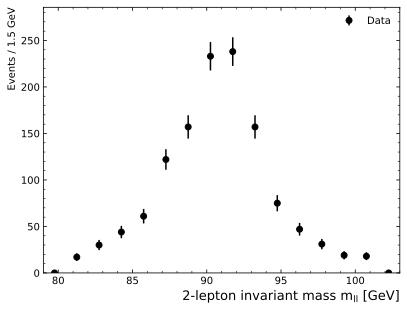

In [47]:
xmin = 79 * GeV
xmax = 103 * GeV

# Histogram bin setup
step_size = 1.5 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values
# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(inv_mass), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# *************
# Main plot 
# *************
main_axes2 = plt.gca() # get current axes

# plot the data points
main_axes2.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes2.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes2.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes2.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes2.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes2.set_ylim( bottom=0, top=np.amax(data_x)*1.2 )

# add minor ticks on y-axis for main axes
main_axes2.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes2.legend( frameon=False ); # no box around the legend

/tmp/ipykernel_48/754518522.py:103: RuntimeWarning: invalid value encountered in divide
  ratio = data_x/mc_heights[0][-1]
/tmp/ipykernel_48/754518522.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)


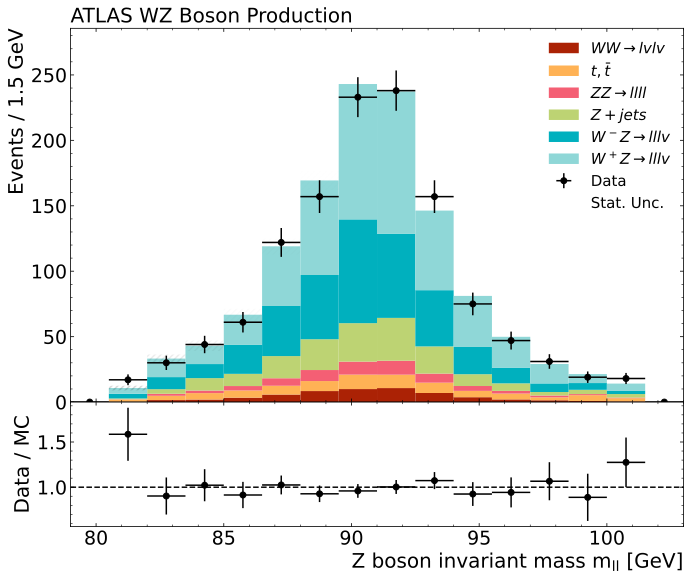

In [48]:
# Define histograms for susy_events_zz
mc_x_zz = np.array(susy_events_zz["inv_mass"])
mc_weights_zz = np.array(susy_events_zz["total_weight"])
mc_colors_zz = "#f45f74" #samples["diboson_leptonic"]['color']
mc_labels_zz = "$ZZ \\to llll$"

# Define histograms for susy_events (the second dataset)
mc_x_wz_p = np.array(susy_events["inv_mass_plus"])
mc_weights_wz_p = np.array(susy_events["total_weight_p"])
mc_colors_wz_p = samples["Zjets"]['color']  # Adjust according to your sample dictionary
mc_labels_wz_p = "$W^+Z \\to lllv$"  # Adjust label as needed

mc_x_wz_m = np.array(susy_events["inv_mass_minus"])
mc_weights_wz_m = np.array(susy_events["total_weight_m"])
mc_colors_wz_m = "#00b0be"  # Adjust according to your sample dictionary
mc_labels_wz_m = "$W^-Z \\to lllv$"  # Adjust label as needed

mc_x_jet = np.array(susy_events_jet["inv_mass"])
mc_weights_jet = np.array(susy_events_jet["total_weight"])
mc_colors_jet = "#bdd373"  # Adjust according to your sample dictionary
mc_labels_jet = "$Z + jets$"  # Adjust label as needed

mc_x_top = np.array(susy_events_top["inv_mass"])
mc_weights_top = np.array(susy_events_top["total_weight"])
mc_colors_top = samples["top"]['color']  # Adjust according to your sample dictionary
mc_labels_top = "$t,\\bar{t}$"  # Adjust label as needed

mc_x_ww = np.array(susy_events_zz["inv_mass"])
mc_weights_ww = np.array(susy_events_zz["total_weight"])
mc_colors_ww = "#AB2205" #samples["diboson_leptonic"]['color']
mc_labels_ww = "$WW \\to lvlv$"

mc_x_all = [mc_x_ww,mc_x_top, mc_x_zz,mc_x_jet, mc_x_wz_m, mc_x_wz_p]
mc_weights_all = [mc_weights_ww,mc_weights_top,mc_weights_zz,mc_weights_jet, mc_weights_wz_m, mc_weights_wz_p]
mc_colors = [mc_colors_ww,mc_colors_top,mc_colors_zz,mc_colors_jet, mc_colors_wz_m, mc_colors_wz_p]
mc_labels = [mc_labels_ww,mc_labels_top,mc_labels_zz,mc_labels_jet, mc_labels_wz_m, mc_labels_wz_p]

# *************
# Main plot 
# *************
fig = plt.figure(figsize=(11, 9))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
main_axes2 = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1], sharex=main_axes2)


# Plot data points
main_axes2.errorbar(
    x=bin_centres, y=data_x, yerr=data_x_errors, xerr=1.5/2,
    fmt='ko', label='Data'
)


# z_jet = main_axes2.hist(
#     mc_x_jet, bins=bin_edges,
#     weights=mc_weights_jet, stacked=True,
#     color=mc_colors_jet, label=mc_labels_jet
# )
#Plot stacked MC histogram (bars add up)
mc_heights = main_axes2.hist(
    mc_x_all, bins=bin_edges,
    weights=mc_weights_all, stacked=True,
    color=mc_colors, label=mc_labels
)

# Total stacked MC content (sum of all heights per bin)
mc_x_tot = mc_heights[0][-1]

# Calculate statistical uncertainty: sqrt(sum of weights^2) per bin
mc_weights_sq_all = [w**2 for w in mc_weights_all]
mc_x_err = np.sqrt(
    sum(np.histogram(x, bins=bin_edges, weights=w_sq)[0]
        for x, w_sq in zip(mc_x_all, mc_weights_sq_all))
)
# mc_x_err = np.sqrt(np.histogram(np.hstack(mc_heights), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# Plot MC stat uncertainty as a hatched band
main_axes2.bar(
    bin_centres, 2 * mc_x_err,
    alpha=0.5, bottom=mc_x_tot - mc_x_err,
    color='none', hatch='////', width=step_size,
    label='Stat. Unc.'
)

# Axis limits and labels
# main_axes2.set_xlim(left=xmin, right=xmax)
main_axes2.set_ylim(bottom=0, top=np.amax(data_x) * 1.2)

# main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
#                        fontsize=13, x=1, horizontalalignment='right')
main_axes2.set_ylabel('Events / ' + str(step_size) + ' GeV',fontsize=20,
                      y=1, horizontalalignment='right')

# Minor ticks and tick style
# main_axes2.xaxis.set_minor_locator(AutoMinorLocator())
main_axes2.yaxis.set_minor_locator(AutoMinorLocator())
main_axes2.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)
main_axes2.tick_params(labelbottom=False)
main_axes2.set_title('ATLAS WZ Boson Production',fontsize=20,loc='left')
# Legend
main_axes2.legend(frameon=False,fontsize=15)

ratio = data_x/mc_heights[0][-1]

ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)

# Plot ratio with data error bars
ratio_axes.errorbar(
    x=bin_centres, y=ratio, yerr=ratio_err,xerr=1.5/2,
    fmt='ko', label='Data / MC'
)
ratio_axes.axhline(1.0, color='black', linestyle='--')
ratio_axes.set_xlim(left=xmin, right=xmax)
# ratio_axes.set_ylim(0.0, 2.0)

ratio_axes.set_xlabel(r'Z boson invariant mass $\mathrm{m_{ll}}$ [GeV]',fontsize=20, x=1, horizontalalignment='right')
ratio_axes.set_ylabel('Data / MC',fontsize=20)

ratio_axes.xaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)

plt.savefig('plots/inv_mass.png')

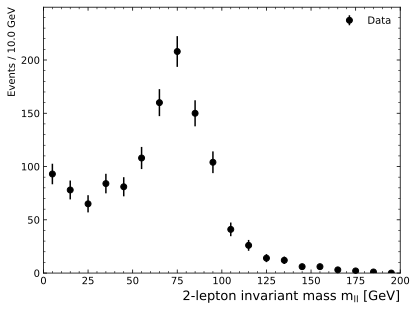

In [49]:
xmin = 0* GeV
xmax = 200 * GeV

# Histogram bin setup
step_size = 10 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(trans_mass), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# *************
# Main plot 
# *************
main_axes1 = plt.gca() # get current axes

# plot the data points
main_axes1.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes1.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes1.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes1.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes1.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes1.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes1.set_ylim( bottom=0, top=np.amax(data_x)*1.2 )

# add minor ticks on y-axis for main axes
main_axes1.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes1.legend( frameon=False ); # no box around the legend

/tmp/ipykernel_48/572609612.py:100: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)


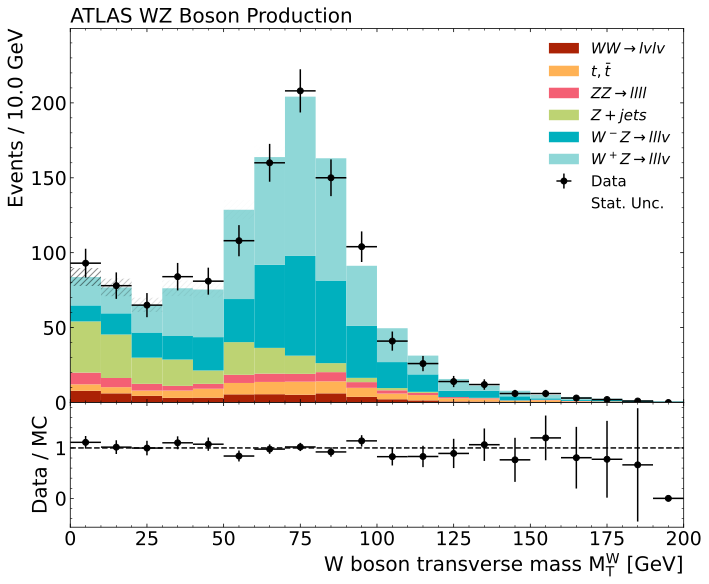

In [50]:
# Define histograms for susy_events_zz
mc_x_zz = np.array(susy_events_zz["trans_mass"])
mc_weights_zz = np.array(susy_events_zz["total_weight"])
mc_colors_zz = "#f45f74" #samples["diboson_leptonic"]['color']
mc_labels_zz = "$ZZ \\to llll$"

# Define histograms for susy_events (the second dataset)
mc_x_wz_p = np.array(susy_events["trans_mass_plus"])
mc_weights_wz_p = np.array(susy_events["total_weight_p"])
mc_colors_wz_p = samples["Zjets"]['color']  # Adjust according to your sample dictionary
mc_labels_wz_p = "$W^+Z \\to lllv$"  # Adjust label as needed

mc_x_wz_m = np.array(susy_events["trans_mass_minus"])
mc_weights_wz_m = np.array(susy_events["total_weight_m"])
mc_colors_wz_m = "#00b0be"  # Adjust according to your sample dictionary
mc_labels_wz_m = "$W^-Z \\to lllv$"  # Adjust label as needed

mc_x_jet = np.array(susy_events_jet["trans_mass"])
mc_weights_jet = np.array(susy_events_jet["total_weight"])
mc_colors_jet = "#bdd373"  # Adjust according to your sample dictionary
mc_labels_jet = "$Z + jets$"  # Adjust label as needed

mc_x_top = np.array(susy_events_top["trans_mass"])
mc_weights_top = np.array(susy_events_top["total_weight"])
mc_colors_top = samples["top"]['color']  # Adjust according to your sample dictionary
mc_labels_top = "$t,\\bar{t}$"  # Adjust label as needed

mc_x_ww = np.array(susy_events_zz["trans_mass"])
mc_weights_ww = np.array(susy_events_zz["total_weight"])
mc_colors_ww = "#AB2205" #samples["diboson_leptonic"]['color']
mc_labels_ww = "$WW \\to lvlv$"

mc_x_all = [mc_x_ww,mc_x_top, mc_x_zz,mc_x_jet, mc_x_wz_m, mc_x_wz_p]
mc_weights_all = [mc_weights_ww,mc_weights_top,mc_weights_zz,mc_weights_jet, mc_weights_wz_m, mc_weights_wz_p]
mc_colors = [mc_colors_ww,mc_colors_top,mc_colors_zz,mc_colors_jet, mc_colors_wz_m, mc_colors_wz_p]
mc_labels = [mc_labels_ww,mc_labels_top,mc_labels_zz,mc_labels_jet, mc_labels_wz_m, mc_labels_wz_p]

# *************
# Main plot 
# *************
fig = plt.figure(figsize=(11, 9))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
main_axes2 = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1], sharex=main_axes2)


# Plot data points
main_axes2.errorbar(
    x=bin_centres, y=data_x, yerr=data_x_errors, xerr=step_size/2,
    fmt='ko', label='Data'
)

# Plot stacked MC histogram (bars add up)
mc_heights = main_axes2.hist(
    mc_x_all, bins=bin_edges,
    weights=mc_weights_all, stacked=True,
    color=mc_colors, label=mc_labels
)

# Total stacked MC content (sum of all heights per bin)
mc_x_tot = mc_heights[0][-1]

# Calculate statistical uncertainty: sqrt(sum of weights^2) per bin
mc_weights_sq_all = [w**2 for w in mc_weights_all]
mc_x_err = np.sqrt(
    sum(np.histogram(x, bins=bin_edges, weights=w_sq)[0]
        for x, w_sq in zip(mc_x_all, mc_weights_sq_all))
)
# mc_x_err = np.sqrt(np.histogram(np.hstack(mc_heights), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# Plot MC stat uncertainty as a hatched band
main_axes2.bar(
    bin_centres, 2 * mc_x_err,
    alpha=0.5, bottom=mc_x_tot - mc_x_err,
    color='none', hatch='////', width=step_size,
    label='Stat. Unc.'
)

# Axis limits and labels
# main_axes2.set_xlim(left=xmin, right=xmax)
main_axes2.set_ylim(bottom=0, top=np.amax(data_x) * 1.2)

# main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
#                        fontsize=13, x=1, horizontalalignment='right')
main_axes2.set_ylabel('Events / ' + str(step_size) + ' GeV',fontsize=20,
                      y=1, horizontalalignment='right')

# Minor ticks and tick style
# main_axes2.xaxis.set_minor_locator(AutoMinorLocator())
main_axes2.yaxis.set_minor_locator(AutoMinorLocator())
main_axes2.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)
main_axes2.tick_params(labelbottom=False)
main_axes2.set_title('ATLAS WZ Boson Production',fontsize=20,loc='left')

# Legend
main_axes2.legend(frameon=False,fontsize=15)

ratio = data_x/mc_heights[0][-1]
ratio = np.where(np.isnan(np.array(ratio)),1,np.array(ratio))
ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)
ratio_err = np.where(np.isnan(np.array(ratio_err)),0,np.array(ratio_err))
# Plot ratio with data error bars
ratio_axes.errorbar(
    x=bin_centres, y=ratio, yerr=ratio_err, xerr=step_size/2,
    fmt='ko', label='Data / MC'
)
ratio_axes.axhline(1.0, color='black', linestyle='--')
ratio_axes.set_xlim(left=xmin, right=xmax)
# ratio_axes.set_ylim(0.0, 2.0)

ratio_axes.set_xlabel(r'W boson transverse mass $\mathrm{M_{T}^W}$ [GeV]',fontsize=20, x=1, horizontalalignment='right')
ratio_axes.set_ylabel('Data / MC',fontsize=20)

ratio_axes.xaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)

plt.savefig('plots/trans_mass.png')


[  0.   7.  14.  21.  28.  35.  42.  49.  56.  63.  70.  77.  84.  91.
  98. 105. 112. 119. 126. 133. 140. 147. 154. 161.] [ 93  78  65  84  81 108 160 208 150 104  41  26  14  12   6   6   3   2
   1   0]


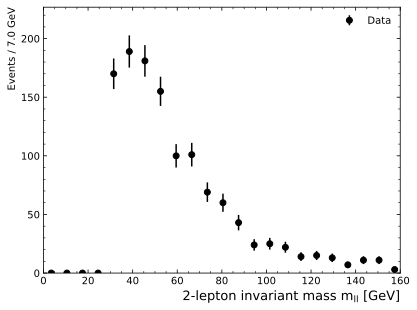

In [51]:
xmin = 0 * GeV
xmax = 160 * GeV

# Histogram bin setup
step_size = 7 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values
print(bin_edges, data_x)
# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(miss_energy), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# *************
# Main plot 
# *************
main_axes2 = plt.gca() # get current axes

# plot the data points
main_axes2.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes2.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes2.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes2.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes2.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes2.set_ylim( bottom=0, top=np.amax(data_x)*1.2 )

# add minor ticks on y-axis for main axes
main_axes2.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes2.legend( frameon=False ); # no box around the legend

/tmp/ipykernel_48/4185914529.py:97: RuntimeWarning: invalid value encountered in divide
  ratio = data_x/mc_heights[0][-1]
/tmp/ipykernel_48/4185914529.py:99: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)


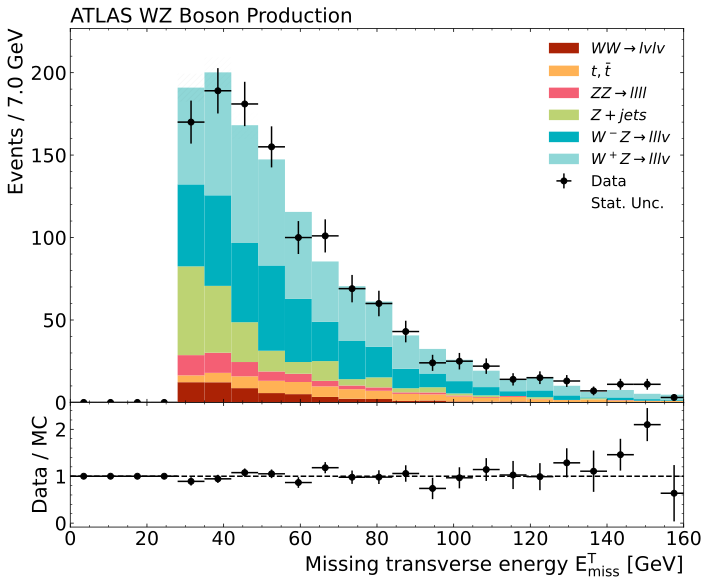

In [52]:
# Define histograms for susy_events_zz
mc_x_zz = np.array(susy_events_zz["miss_e"])
mc_weights_zz = np.array(susy_events_zz["total_weight"])
mc_colors_zz = "#f45f74" #samples["diboson_leptonic"]['color']
mc_labels_zz = "$ZZ \\to llll$"

mc_x_wz_p = np.array(susy_events["miss_e_plus"])
mc_weights_wz_p = np.array(susy_events["total_weight_p"])
mc_colors_wz_p = samples["Zjets"]['color']  # Adjust according to your sample dictionary
mc_labels_wz_p = "$W^+Z \\to lllv$"  # Adjust label as needed

mc_x_wz_m = np.array(susy_events["miss_e_minus"])
mc_weights_wz_m = np.array(susy_events["total_weight_m"])
mc_colors_wz_m = "#00b0be"  # Adjust according to your sample dictionary
mc_labels_wz_m = "$W^-Z \\to lllv$"  # Adjust label as needed

mc_x_jet = np.array(susy_events_jet["miss_e"])
mc_weights_jet = np.array(susy_events_jet["total_weight"])
mc_colors_jet = "#bdd373"  # Adjust according to your sample dictionary
mc_labels_jet = "$Z + jets$"  # Adjust label as needed

mc_x_top = np.array(susy_events_top["miss_e"])
mc_weights_top = np.array(susy_events_top["total_weight"])
mc_colors_top = samples["top"]['color']  # Adjust according to your sample dictionary
mc_labels_top = "$t,\\bar{t}$"  # Adjust label as needed

mc_x_ww = np.array(susy_events_zz["miss_e"])
mc_weights_ww = np.array(susy_events_zz["total_weight"])
mc_colors_ww = "#AB2205" #samples["diboson_leptonic"]['color']
mc_labels_ww = "$WW \\to lvlv$"

mc_x_all = [mc_x_ww,mc_x_top, mc_x_zz,mc_x_jet, mc_x_wz_m, mc_x_wz_p]
mc_weights_all = [mc_weights_ww,mc_weights_top,mc_weights_zz,mc_weights_jet, mc_weights_wz_m, mc_weights_wz_p]
mc_colors = [mc_colors_ww,mc_colors_top,mc_colors_zz,mc_colors_jet, mc_colors_wz_m, mc_colors_wz_p]
mc_labels = [mc_labels_ww,mc_labels_top,mc_labels_zz,mc_labels_jet, mc_labels_wz_m, mc_labels_wz_p]

# *************
# Main plot 
# *************
fig = plt.figure(figsize=(11, 9))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
main_axes2 = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1], sharex=main_axes2)


# Plot data points
main_axes2.errorbar(
    x=bin_centres, y=data_x, yerr=data_x_errors, xerr=step_size/2,
    fmt='ko', label='Data'
)

# Plot stacked MC histogram (bars add up)
mc_heights = main_axes2.hist(
    mc_x_all, bins=bin_edges,
    weights=mc_weights_all, stacked=True,
    color=mc_colors, label=mc_labels
)

# Total stacked MC content (sum of all heights per bin)
mc_x_tot = mc_heights[0][-1]

# Calculate statistical uncertainty: sqrt(sum of weights^2) per bin
mc_weights_sq_all = [w**2 for w in mc_weights_all]
mc_x_err = np.sqrt(
    sum(np.histogram(x, bins=bin_edges, weights=w_sq)[0]
        for x, w_sq in zip(mc_x_all, mc_weights_sq_all))
)
# mc_x_err = np.sqrt(np.histogram(np.hstack(mc_heights), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# Plot MC stat uncertainty as a hatched band
main_axes2.bar(
    bin_centres, 2 * mc_x_err,
    alpha=0.5, bottom=mc_x_tot - mc_x_err,
    color='none', hatch='////', width=step_size,
    label='Stat. Unc.'
)

# Axis limits and labels
# main_axes2.set_xlim(left=xmin, right=xmax)
main_axes2.set_ylim(bottom=0, top=np.amax(data_x) * 1.2)

# main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
#                        fontsize=13, x=1, horizontalalignment='right')
main_axes2.set_ylabel('Events / ' + str(step_size) + ' GeV',fontsize=20,
                      y=1, horizontalalignment='right')

# Minor ticks and tick style
# main_axes2.xaxis.set_minor_locator(AutoMinorLocator())
main_axes2.yaxis.set_minor_locator(AutoMinorLocator())
main_axes2.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)
main_axes2.tick_params(labelbottom=False)
main_axes2.set_title('ATLAS WZ Boson Production',fontsize=20,loc='left')

# Legend
main_axes2.legend(frameon=False,fontsize=15)

ratio = data_x/mc_heights[0][-1]
ratio = np.where(np.isnan(np.array(ratio)),1,np.array(ratio))
ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)
ratio_err = np.where(np.isnan(np.array(ratio_err)),0,np.array(ratio_err))
# Plot ratio with data error bars
ratio_axes.errorbar(
    x=bin_centres, y=ratio, yerr=ratio_err, xerr=step_size/2,
    fmt='ko', label='Data / MC'
)
ratio_axes.axhline(1.0, color='black', linestyle='--')
ratio_axes.set_xlim(left=xmin, right=xmax)
# ratio_axes.set_ylim(0.0, 2.0)

ratio_axes.set_xlabel(r'Missing transverse energy $\mathrm{E_{miss}^T}$ [GeV]',fontsize=20, x=1, horizontalalignment='right')
ratio_axes.set_ylabel('Data / MC',fontsize=20)

ratio_axes.xaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)

plt.savefig('plots/miss_e.png')

[  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400.] [  0   0   0   0 170 189 181 155 100 101  69  60  43  24  25  22  14  15
  13   7  11  11   3]


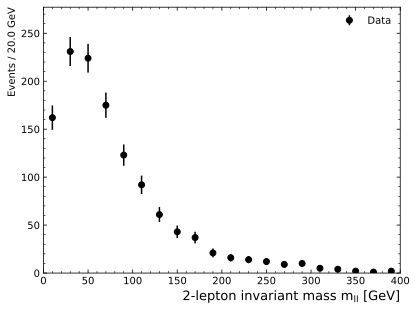

In [53]:
xmin = 0 * GeV
xmax = 400 * GeV

# Histogram bin setup
step_size = 20 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values
print(bin_edges, data_x)
# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(pts), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# *************
# Main plot 
# *************
main_axes2 = plt.gca() # get current axes

# plot the data points
main_axes2.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes2.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes2.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes2.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes2.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes2.set_ylim( bottom=0, top=np.amax(data_x)*1.2 )

# add minor ticks on y-axis for main axes
main_axes2.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes2.legend( frameon=False ); # no box around the legend

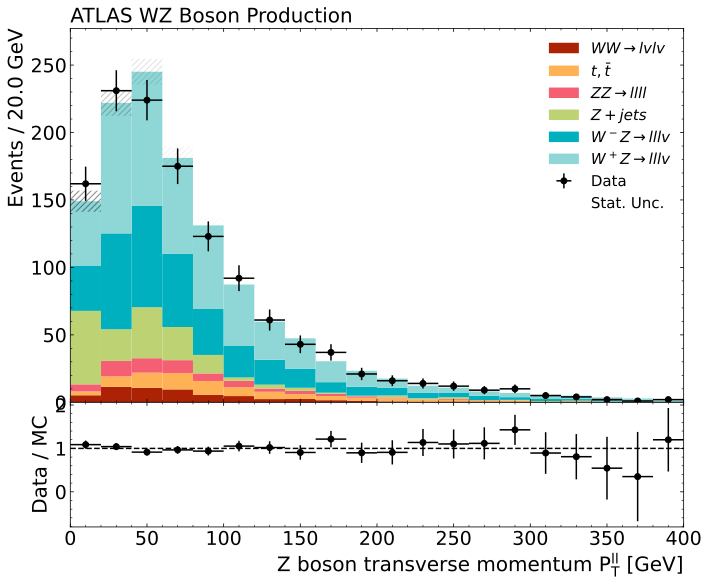

In [54]:

# Define histograms for susy_events_zz
mc_x_zz = np.array(susy_events_zz['pt'])
mc_weights_zz = np.array(susy_events_zz["total_weight"])
mc_colors_zz = "#f45f74" #samples["diboson_leptonic"]['color']
mc_labels_zz = "$ZZ \\to llll$"

mc_x_wz_p = np.array(susy_events["pt_plus"])
mc_weights_wz_p = np.array(susy_events["total_weight_p"])
mc_colors_wz_p = samples["Zjets"]['color']  # Adjust according to your sample dictionary
mc_labels_wz_p = "$W^+Z \\to lllv$"  # Adjust label as needed

mc_x_wz_m = np.array(susy_events["pt_minus"])
mc_weights_wz_m = np.array(susy_events["total_weight_m"])
mc_colors_wz_m = "#00b0be"  # Adjust according to your sample dictionary
mc_labels_wz_m = "$W^-Z \\to lllv$"  # Adjust label as needed

mc_x_jet = np.array(susy_events_jet["pt"])
mc_weights_jet = np.array(susy_events_jet["total_weight"])
mc_colors_jet = "#bdd373"  # Adjust according to your sample dictionary
mc_labels_jet = "$Z + jets$"  # Adjust label as needed

mc_x_top = np.array(susy_events_top["pt"])
mc_weights_top = np.array(susy_events_top["total_weight"])
mc_colors_top = samples["top"]['color']  # Adjust according to your sample dictionary
mc_labels_top = "$t,\\bar{t}$"  # Adjust label as needed

mc_x_ww = np.array(susy_events_zz["pt"])
mc_weights_ww = np.array(susy_events_zz["total_weight"])
mc_colors_ww = "#AB2205" #samples["diboson_leptonic"]['color']
mc_labels_ww = "$WW \\to lvlv$"

mc_x_all = [mc_x_ww,mc_x_top, mc_x_zz,mc_x_jet, mc_x_wz_m, mc_x_wz_p]
mc_weights_all = [mc_weights_ww,mc_weights_top,mc_weights_zz,mc_weights_jet, mc_weights_wz_m, mc_weights_wz_p]
mc_colors = [mc_colors_ww,mc_colors_top,mc_colors_zz,mc_colors_jet, mc_colors_wz_m, mc_colors_wz_p]
mc_labels = [mc_labels_ww,mc_labels_top,mc_labels_zz,mc_labels_jet, mc_labels_wz_m, mc_labels_wz_p]

# *************
# Main plot 
# *************
fig = plt.figure(figsize=(11, 9))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
main_axes2 = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1], sharex=main_axes2)


# Plot data points
main_axes2.errorbar(
    x=bin_centres, y=data_x, yerr=data_x_errors, xerr=step_size/2,
    fmt='ko', label='Data'
)

# Plot stacked MC histogram (bars add up)
mc_heights = main_axes2.hist(
    mc_x_all, bins=bin_edges,
    weights=mc_weights_all, stacked=True,
    color=mc_colors, label=mc_labels
)

# Total stacked MC content (sum of all heights per bin)
mc_x_tot = mc_heights[0][-1]

# Calculate statistical uncertainty: sqrt(sum of weights^2) per bin
mc_weights_sq_all = [w**2 for w in mc_weights_all]
mc_x_err = np.sqrt(
    sum(np.histogram(x, bins=bin_edges, weights=w_sq)[0]
        for x, w_sq in zip(mc_x_all, mc_weights_sq_all))
)
# mc_x_err = np.sqrt(np.histogram(np.hstack(mc_heights), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# Plot MC stat uncertainty as a hatched band
main_axes2.bar(
    bin_centres, 2 * mc_x_err,
    alpha=0.5, bottom=mc_x_tot - mc_x_err,
    color='none', hatch='////', width=step_size,
    label='Stat. Unc.'
)

# Axis limits and labels
# main_axes2.set_xlim(left=xmin, right=xmax)
main_axes2.set_ylim(bottom=0, top=np.amax(data_x) * 1.2)

# main_axes2.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
#                        fontsize=13, x=1, horizontalalignment='right')
main_axes2.set_ylabel('Events / ' + str(step_size) + ' GeV',fontsize=20,
                      y=1, horizontalalignment='right')

# Minor ticks and tick style
# main_axes2.xaxis.set_minor_locator(AutoMinorLocator())
main_axes2.yaxis.set_minor_locator(AutoMinorLocator())
main_axes2.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)
main_axes2.tick_params(labelbottom=False)
main_axes2.set_title('ATLAS WZ Boson Production',fontsize=20,loc='left')

# Legend
main_axes2.legend(frameon=False,fontsize=15)

ratio = data_x/mc_heights[0][-1]
ratio = np.where(np.isnan(np.array(ratio)),1,np.array(ratio))
ratio_err = np.sqrt((data_x_errors/data_x)**2 + (mc_x_err/mc_heights[0][-1])**2)
ratio_err = np.where(np.isnan(np.array(ratio_err)),0,np.array(ratio_err))
# Plot ratio with data error bars
ratio_axes.errorbar(
    x=bin_centres, y=ratio, yerr=ratio_err, xerr=step_size/2,
    fmt='ko', label='Data / MC'
)
ratio_axes.axhline(1.0, color='black', linestyle='--')
ratio_axes.set_xlim(left=xmin, right=xmax)
# ratio_axes.set_ylim(0.0, 2.0)

ratio_axes.set_xlabel(r'Z boson transverse momentum $\mathrm{P_{T}^{ll}}$ [GeV]',fontsize=20, x=1, horizontalalignment='right')
ratio_axes.set_ylabel('Data / MC',fontsize=20)

ratio_axes.xaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
ratio_axes.tick_params(which='both', direction='in', top=True, right=True, labelsize=19)

plt.savefig('plots/pt.png')